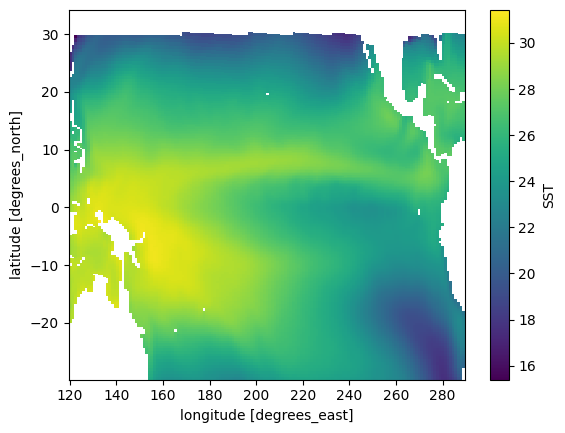

array([(94, 143), (94, 144), (94, 145), ..., (279, 291), (279, 292),
       (279, 293)], dtype=object)

In [18]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pickle

SST_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific_SST.pkl"
AREAS_DATA_DIR = "/l/users/minghao.fu/dataset/CESM2/group_region/"
SPACE_INDEX_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific.pkl"
#load data
#replace "CESM2_pacific_SST" with the file you which to visualize.
f = open(SST_DATA_PATH, 'rb')
SST = pickle.load(f)
f.close()
#metadata file
f = open(SPACE_INDEX_DATA_PATH, 'rb')
coords = pickle.load(f).drop_dims('time')
f.close()

#visualize input data using metadata
tSST = np.empty(coords.dims.get('space_index'))
tSST[~coords.nnaSST]=np.nan
tSST[coords.nnaSST] = SST[0]
tst = coords.copy()
tst['SST']=('space_index', tSST)
tst.unstack('space_index').SST.plot(x='lon', y='lat')
plt.show()
tst.unstack('space_index').SST.nlat


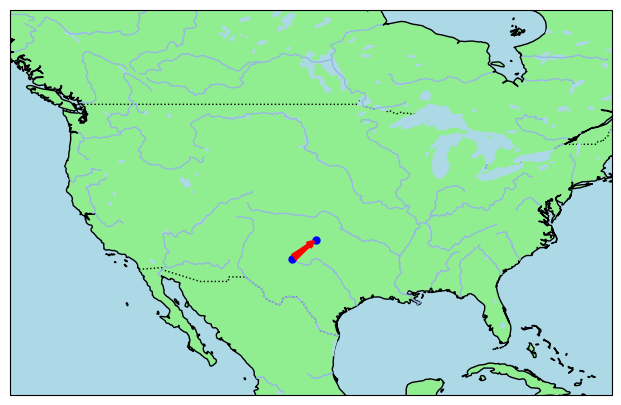

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Example coordinates (Longitude, Latitude)
start_coords = [-101.877, 33.583]  # Example: Starting point
end_coords = [-99.512, 35.481]     # Example: Ending point

# Create a figure with a map projection
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.LAND, color='lightgreen')   # Color the land
ax.add_feature(cfeature.OCEAN, color='lightblue')   # Color the oceans
ax.add_feature(cfeature.COASTLINE)                  # Add coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':')     # Add country borders
ax.add_feature(cfeature.LAKES, color='lightblue')   # Color the lakes
ax.add_feature(cfeature.RIVERS)                     # Add rivers

# Define the geographic bounds of the map
ax.set_extent([-130, -70, 20, 55])  # Adjust as needed

# Plot the start and end points
ax.plot([start_coords[0], end_coords[0]], [start_coords[1], end_coords[1]],
        color='blue', marker='o', markersize=5, transform=ccrs.Geodetic())

# Draw a customized arrow from start to end point
ax.annotate('', xy=(end_coords[0], end_coords[1]), xytext=(start_coords[0], start_coords[1]),
            arrowprops=dict(arrowstyle="fancy", color='red', lw=2),
            transform=ccrs.Geodetic())

plt.show()


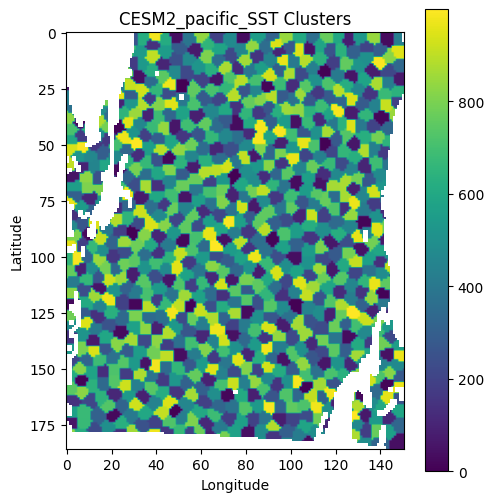

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pickle
import itertools
import glob
import warnings
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

from minghao_utils import *
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore")

SST_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific_SST.pkl"
AREAS_DATA_DIR = "/l/users/minghao.fu/dataset/CESM2/group_region/"
SPACE_INDEX_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific.pkl"
VIS_DIR_PATH = "/l/users/minghao.fu/dataset/CESM2/figures/"
ANIMATE_PATH = "/l/users/minghao.fu/dataset/CESM2/animation"

TS_LEN=3

# replace "CESM2_pacific_SST" with the file you which to visualize.
f = open(SST_DATA_PATH, 'rb')
SST = pickle.load(f)
f.close()
# metadata file
f = open(SPACE_INDEX_DATA_PATH, 'rb')
coords = pickle.load(f).drop_dims('time')
f.close()


n_samples = SST.shape[0]
n_dims = coords.dims.get('space_index')
n_valid_dims = SST.shape[1]

corr = np.corrcoef(SST[:, :130].T)

tSST = np.empty((SST.shape[0], coords.dims.get('space_index')))
tSST[:, ~coords.nnaSST] = np.nan
tSST[:, coords.nnaSST] = SST  #(6000, 28086)

tst = coords.copy()
tst['SST']=('space_index', tSST[0])
lat_len, lon_len = tst.unstack('space_index').SST.values.shape

coords_SST = tSST.copy().reshape(tSST.shape[0], lat_len, lon_len) #tst.unstack('space_index').SST.values

coords_flat = coords['space_index'].values
coords_flat[~coords.nnaSST] = np.nan
coords_mat = coords_flat.reshape(lat_len, lon_len)
coords_bin_mat = coords.nnaSST.values.reshape(lat_len, lon_len)

max_distance = 40
coords_groups = []
SST_groups = []

coords_SST[:, ~coords.nnaSST.values.reshape(lat_len, lon_len)] = 0
# Example 2D matrices

coords_SST0 = coords_SST[0]  # Replace with your actual data

rows, cols = coords_SST0.shape

# Function to create dataset with coordinates
def matrix_to_dataset(matrix):
    rows, cols = matrix.shape
    return np.array([[row, col] for row in range(rows) for col in range(cols)]) #matrix[row, col], 

# Create datasets for each matrix
dataset1 = matrix_to_dataset(coords_SST0)

# Combine datasets

# Define the number of clusters
k = 1000  # Adjust based on your requirements

# Apply K-means clustering
kmeans = KMeans(n_clusters=k)
kmeans.fit(dataset1)

# Get cluster labels
labels = kmeans.labels_
centers = kmeans.cluster_centers_
group_regions = [[] for i in range(k)]

# Function to create a color-coded cluster matrix
def create_cluster_matrix(matrix, labels):
    cluster_matrix = np.zeros_like(matrix)
    rows, cols = matrix.shape
    for row in range(rows):
        for col in range(cols):
            cluster_matrix[row, col] = labels[row * cols + col] if coords_bin_mat[row, col] else -1
            group_regions[labels[row * cols + col]].append((row, col))
    return cluster_matrix
# Create cluster matrices
cluster_coords_SST0 = create_cluster_matrix(coords_SST0, labels)  

# Mask the array: mask 0 values
masked_array = np.ma.masked_where(cluster_coords_SST0 == -1, cluster_coords_SST0)

# Define a colormap: 'viridis' but with a custom color for masked values (white)
cmap = plt.cm.viridis
cmap.set_bad(color='white')


# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("CESM2_pacific_SST Clusters")
#plt.imshow(cluster_coords_SST0, cmap='viridis')
plt.imshow(masked_array, cmap=cmap)  # Use the masked array here
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar()

plt.show()

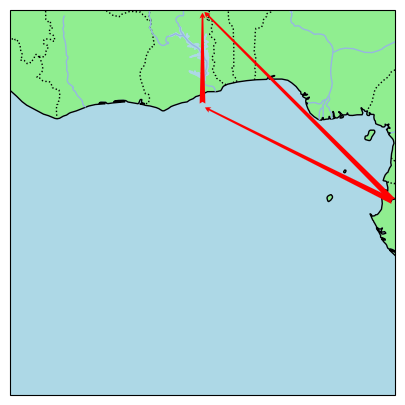

In [4]:
from minghao_utils import plot_DAG_on_map
from matplotlib import pyplot as plt   
import numpy as np 
DAG = [[0,0,0], 
       [1,0,1], 
       [1,0,0]]
coords = np.array([[10,0], [0,10], [0, 5]])
extent=[-10, 10, -10, 10]
fig = plot_DAG_on_map(DAG, coords, extent, save_path=None)
plt.savefig("./DAG_on_map.png")

In [ ]:
import matplotlib.pyplot as plt
import imageio

import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pickle
import cv2
import os
import glob
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
from Caulimate.Utils.Tools import makedir
from Caulimate.Utils.Visualization import video_from_figs_list, figures_slider_display, call_ffmpeg_generate_video
import warnings
warnings.filterwarnings("ignore")

SST_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific_SST.pkl"
SPACE_INDEX_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific.pkl"
VIS_DIR = "/l/users/minghao.fu/dataset/CESM2/figures/"
VIDEO_PATH = "/l/users/minghao.fu/dataset/CESM2/pacific_video.mp4"

def save_visualize_CESM2_figs(sst_path, space_index_path, vis_dir):
    f = open(sst_path, 'rb')
    SST = pickle.load(f)
    f.close()
    # metadata file
    f = open(space_index_path, 'rb')
    coords = pickle.load(f).drop_dims('time')
    f.close()

    coords['space_index'].values[coords.nnaSST]

    makedir(vis_dir)

    plot_functions = [] 
    for i in tqdm(range(len(SST))):
        #visualize input data using metadata
        tSST = np.empty(coords.dims.get('space_index'))
        tSST[~coords.nnaSST]=np.nan
        tSST[coords.nnaSST] = SST[i]
        tst = coords.copy()
        tst['SST']=('space_index', tSST)
        tst.unstack('space_index').SST.plot(x='lon', y='lat')
        plot_functions.append(plt)
        plt.title('CESM2_pacific_SST at time step {}'.format(i))
        plt.savefig(os.path.join(vis_dir, str(i)+'.png'))
        plt.close()
        
    call_ffmpeg_generate_video(vis_dir, '', suffix='.png')

save_visualize_CESM2_figs(SST_DATA_PATH, SPACE_INDEX_DATA_PATH, VIS_DIR)
create_video_from_figs(VIS_DIR, VIDEO_PATH)